# 📊 Market Sentiment & Trader Performance Analysis

**Objective:**  
Analyze how trader performance (PnL, trade volume, win rates) relates to market sentiment, measured by the **Fear & Greed Index**.  
This analysis will explore patterns such as:
- Do traders perform better during Fear or Greed periods?
- How does sentiment impact overall market PnL and trading activity?
- Which accounts adapt best under different sentiment regimes?

**Datasets:**  
1. `historical_data.csv` → Trade-level data (accounts, prices, sizes, PnL, timestamps).  
2. `fear_greed_index.csv` → Daily sentiment index (0 = extreme fear, 100 = extreme greed).  

**Approach:**  
1. Load and clean the datasets.  
2. Perform exploratory data analysis (EDA).  
3. Aggregate trades per day and merge with sentiment data.  
4. Visualize relationships between sentiment and trader performance.  
5. Conduct statistical tests for significance.  
6. Analyze account-level performance across sentiment categories.  


In [ ]:
# STEP 2: Load & Inspect Data

import pandas as pd
import numpy as np

# For plots
import matplotlib.pyplot as plt

# For statistical tests
from scipy import stats

# Upload files
from google.colab import files

print("👉 Please upload historical_data.csv")
uploaded_hist = files.upload()

print("👉 Please upload fear_greed_index.csv")
uploaded_fg = files.upload()

# Load into DataFrames
hist = pd.read_csv("historical_data.csv")
fg = pd.read_csv("fear_greed_index.csv")

# Preview shapes and first few rows
print("Historical data shape:", hist.shape)
print("Fear & Greed shape:", fg.shape)

print("\n--- Historical data sample ---")
display(hist.head())

print("\n--- Fear & Greed Index sample ---")
display(fg.head())


👉 Please upload historical_data.csv


Saving historical_data.csv to historical_data.csv
👉 Please upload fear_greed_index.csv


Saving fear_greed_index.csv to fear_greed_index.csv
Historical data shape: (211224, 16)
Fear & Greed shape: (2644, 4)

--- Historical data sample ---


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



--- Fear & Greed Index sample ---


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
# STEP 3: Data Cleaning & Preprocessing

# --- 1. Normalize column names ---
def normalize_cols(df):
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

hist = normalize_cols(hist)
fg = normalize_cols(fg)

print("Columns in historical data:", list(hist.columns))
print("Columns in Fear & Greed data:", list(fg.columns))

# --- 2. Parse dates ---
# Fear & Greed
fg['date'] = pd.to_datetime(fg['date'], errors='coerce')
fg['date'] = fg['date'].dt.date   # keep only date part

# Historical
if 'timestamp_ist' in hist.columns:
    hist['date'] = pd.to_datetime(hist['timestamp_ist'], errors='coerce')
elif 'timestamp' in hist.columns:
    hist['date'] = pd.to_datetime(hist['timestamp'], unit='s', errors='coerce')
else:
    hist['date'] = pd.NaT

hist['date'] = pd.to_datetime(hist['date'], errors='coerce')
hist['date'] = hist['date'].dt.date   # ensure proper date type

# Filter out NaT values before getting min/max date
valid_dates_hist = hist['date'].dropna()
valid_dates_fg = fg['date'].dropna()


# --- 6. Check date ranges safely ---
print("Historical data date range:", valid_dates_hist.min(), "→", valid_dates_hist.max())
print("Fear & Greed Index date range:", valid_dates_fg.min(), "→", valid_dates_fg.max())


# --- 5. Drop duplicates (by transaction_hash if available) ---
before = hist.shape[0]
if 'transaction_hash' in hist.columns:
    hist = hist.drop_duplicates(subset=['transaction_hash'])
else:
    hist = hist.drop_duplicates()
after = hist.shape[0]
print(f"Dropped {before - after} duplicate rows")

# --- 6. Check date ranges ---
print("Historical data date range:", valid_dates_hist.min(), "→", valid_dates_hist.max())
print("Fear & Greed Index date range:", valid_dates_fg.min(), "→", valid_dates_fg.max())

# --- 7. Preview cleaned data ---
print("\n--- Cleaned historical sample ---")
display(hist.head())

print("\n--- Cleaned Fear & Greed sample ---")
display(fg.head())

Columns in historical data: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'date', 'profitable']
Columns in Fear & Greed data: ['timestamp', 'value', 'classification', 'date']
Historical data date range: 2023-01-05 → 2025-12-04
Fear & Greed Index date range: 2018-02-01 → 2025-05-02
Dropped 0 duplicate rows
Historical data date range: 2023-01-05 → 2025-12-04
Fear & Greed Index date range: 2018-02-01 → 2025-05-02

--- Cleaned historical sample ---


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date,profitable
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,False
11,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9457,7.27,57.77,BUY,02-12-2024 22:51,2998.950000,Buy,0.0,0x21b8b230ad8a3e9ae1bb041841332f02028300681b0d...,52018049026,True,0.002544,9.380000e+14,1.730000e+12,2024-02-12,False
15,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9271,100.00,792.71,BUY,02-12-2024 22:54,5000.249301,Buy,0.0,0xef8b5ed662586d4455030418413ecd01f3009832c599...,52019096364,True,0.035000,3.500000e+13,1.730000e+12,2024-02-12,False
31,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.4791,2.00,14.96,BUY,02-12-2024 23:13,6999.549302,Buy,0.0,0x40a5eae7d00acbbfc3c7041841836c02010a00f9d7d3...,52025109688,True,0.000700,1.040000e+15,1.730000e+12,2024-02-12,False
35,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.5204,100.00,752.04,BUY,02-12-2024 23:21,8998.849302,Buy,0.0,0xd273459b8ff175c0c53d041841a2b00201f80053c9ad...,52027812614,True,0.035000,3.020000e+14,1.730000e+12,2024-02-12,False



--- Cleaned Fear & Greed sample ---


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


--- Distribution of Closed PnL ---


,closed_pnl
count,101184.000000
mean,56.954723
std,1101.825807
min,-117990.104100
25%,0.000000
50%,0.000000
75%,4.032548
max,135329.090100


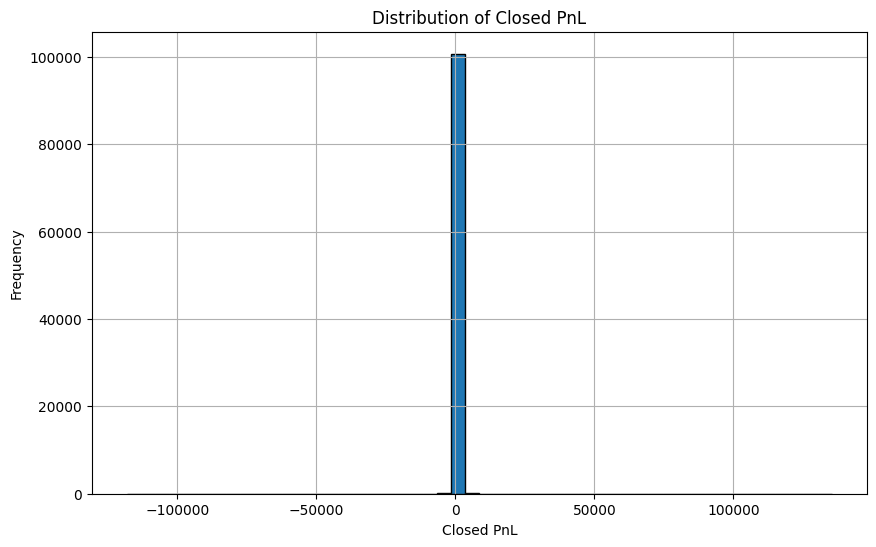


--- Distribution of Trade Size (USD) ---


,size_usd
count,1.011840e+05
mean,4.242173e+03
std,3.977517e+04
min,0.000000e+00
25%,1.651475e+02
50%,5.261800e+02
75%,1.581787e+03
max,3.921431e+06


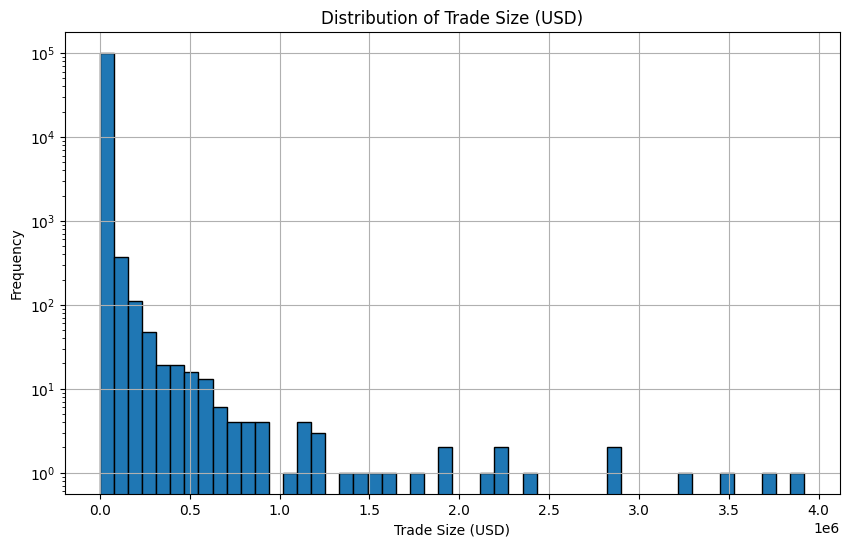


--- Distribution of Fear & Greed Index Value ---


,value
count,2644.000000
mean,46.981089
std,21.827680
min,5.000000
25%,28.000000
50%,46.000000
75%,66.000000
max,95.000000


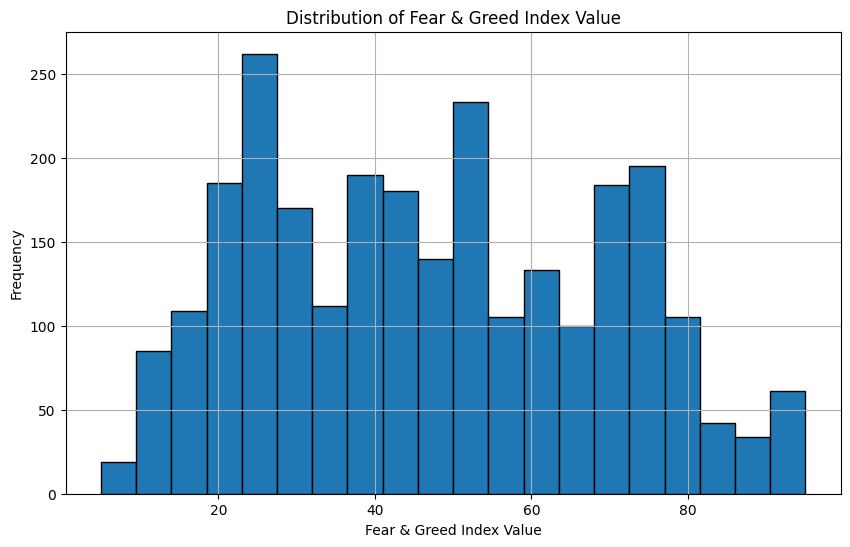


--- Distribution of Fear & Greed Index Classification ---


,count
classification,
Fear,781
Greed,633
Extreme Fear,508
Neutral,396
Extreme Greed,326


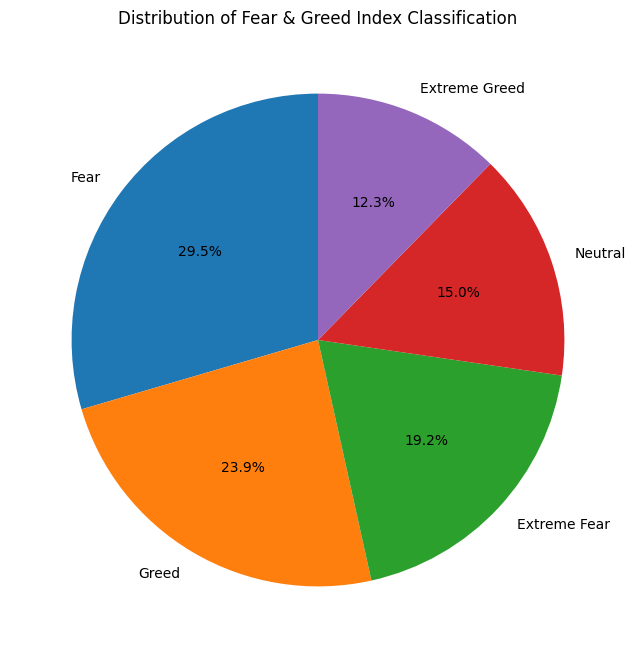

In [6]:
# STEP 4: Exploratory Data Analysis (EDA)

# --- 1. Distribution of PnL ---
print("--- Distribution of Closed PnL ---")
display(hist['closed_pnl'].describe())

plt.figure(figsize=(10, 6))
plt.hist(hist['closed_pnl'], bins=50, edgecolor='k')
plt.title('Distribution of Closed PnL')
plt.xlabel('Closed PnL')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# --- 2. Distribution of Trade Volume (Size USD) ---
print("\n--- Distribution of Trade Size (USD) ---")
display(hist['size_usd'].describe())

plt.figure(figsize=(10, 6))
plt.hist(hist['size_usd'], bins=50, edgecolor='k')
plt.title('Distribution of Trade Size (USD)')
plt.xlabel('Trade Size (USD)')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale due to potential outliers
plt.grid(True)
plt.show()

# --- 3. Distribution of Fear & Greed Index Value ---
print("\n--- Distribution of Fear & Greed Index Value ---")
display(fg['value'].describe())

plt.figure(figsize=(10, 6))
plt.hist(fg['value'], bins=20, edgecolor='k')
plt.title('Distribution of Fear & Greed Index Value')
plt.xlabel('Fear & Greed Index Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# --- 4. Distribution of Fear & Greed Index Classification ---
print("\n--- Distribution of Fear & Greed Index Classification ---")
display(fg['classification'].value_counts())

plt.figure(figsize=(8, 8))
fg['classification'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Fear & Greed Index Classification')
plt.ylabel('') # Hide the default y-label
plt.show()

🔍 Missing values in historical data:


,0
date,62215
account,0
coin,0
execution_price,0
size_usd,0
size_tokens,0
timestamp_ist,0
start_position,0
direction,0
side,0



🔍 Missing values in Fear & Greed data:


,0
timestamp,0
value,0
classification,0
date,0



📊 Summary statistics (historical numeric columns):


,count,mean,std,min,25%,50%,75%,max
closed_pnl,101184.0,56.954723,1101.825807,-117990.104100,0.000000,0.000000,4.032548,1.353291e+05
execution_price,101184.0,9926.197766,27796.209593,0.000005,1.449000,16.818000,106.370000,1.090040e+05
size_tokens,101184.0,6943.248119,137702.843230,0.000010,3.330000,37.420000,304.450000,1.582244e+07
size_usd,101184.0,4242.173228,39775.170049,0.000000,165.147500,526.180000,1581.787500,3.921431e+06
fee,101184.0,0.459060,4.311162,-1.175712,0.008663,0.049494,0.174958,7.543072e+02



📊 Summary statistics (Fear & Greed index values):


,sentiment_value_summary
count,2644.000000
mean,46.981089
std,21.827680
min,5.000000
25%,28.000000
50%,46.000000
75%,66.000000
max,95.000000



🔢 Unique values in account: 32


,count
account,
0xbaaaf6571ab7d571043ff1e313a9609a10637864,11816
0xa0feb3725a9335f49874d7cd8eaad6be45b27416,11135
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,10426
0x8477e447846c758f5a675856001ea72298fd9cb5,10228
0xbee1707d6b44d4d52bfe19e41f8a828645437aab,9275
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,7462
0x47add9a56df66b524d5e2c1993a43cde53b6ed85,5541
0x8170715b3b381dffb7062c0298972d4727a0a63b,3768
0x39cef799f8b69da1995852eea189df24eb5cae3c,3251



🔢 Unique values in coin: 231


,count
coin,
HYPE,25220
@107,10514
BTC,10137
ETH,6995
SOL,4729
MELANIA,3861
FARTCOIN,2161
XRP,1596
WLD,1413



🔢 Unique values in side: 2


,count
side,
BUY,50837
SELL,50347



🔢 Unique values in direction: 12


,count
direction,
Open Long,25155
Close Long,21952
Open Short,21510
Close Short,18953
Sell,6832
Buy,6673
Short > Long,54
Long > Short,47
Spot Dust Conversion,5


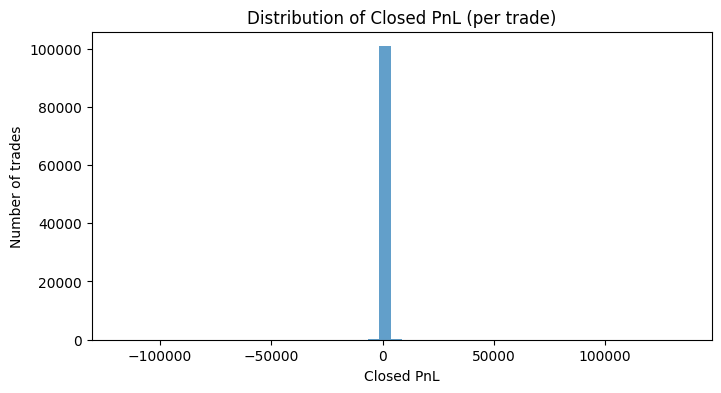

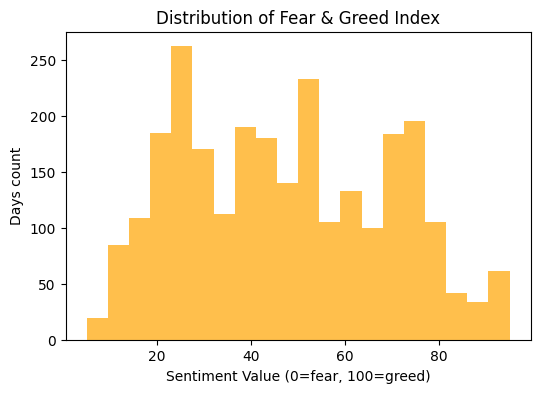

In [7]:
# STEP 4: Exploratory Data Analysis (EDA)

# --- 1. Missing values ---
print("🔍 Missing values in historical data:")
display(hist.isna().sum().sort_values(ascending=False).head(20))

print("\n🔍 Missing values in Fear & Greed data:")
display(fg.isna().sum().sort_values(ascending=False))

# --- 2. Basic statistics for numerical columns ---
numeric_cols = ['closed_pnl','execution_price','size_tokens','size_usd','fee']
print("\n📊 Summary statistics (historical numeric columns):")
display(hist[numeric_cols].describe().T)

print("\n📊 Summary statistics (Fear & Greed index values):")
display(fg['value'].describe().to_frame("sentiment_value_summary"))

# --- 3. Unique values for categorical columns ---
for col in ['account','coin','side','direction']:
    if col in hist.columns:
        print(f"\n🔢 Unique values in {col}: {hist[col].nunique()}")
        display(hist[col].value_counts().head(10))

# --- 4. Distribution plots ---
import matplotlib.pyplot as plt

# A. Closed PnL distribution (per trade)
plt.figure(figsize=(8,4))
plt.hist(hist['closed_pnl'].dropna(), bins=50, alpha=0.7)
plt.title("Distribution of Closed PnL (per trade)")
plt.xlabel("Closed PnL")
plt.ylabel("Number of trades")
plt.show()

# B. Fear & Greed index distribution
plt.figure(figsize=(6,4))
plt.hist(fg['value'].dropna(), bins=20, alpha=0.7, color='orange')
plt.title("Distribution of Fear & Greed Index")
plt.xlabel("Sentiment Value (0=fear, 100=greed)")
plt.ylabel("Days count")
plt.show()


In [8]:
# STEP 5: Daily Aggregation + Sentiment Merge

# --- 1. Aggregate trade data by day ---
agg_daily = hist.groupby('date').agg(
    trades_count=('account','count'),
    total_closed_pnl=('closed_pnl','sum'),
    mean_closed_pnl=('closed_pnl','mean'),
    median_closed_pnl=('closed_pnl','median'),
    profitable_trades=('profitable','sum'),
    profitable_rate=('profitable','mean'),
    total_volume_usd=('size_usd','sum'),
    avg_trade_size_usd=('size_usd','mean'),
    avg_execution_price=('execution_price','mean'),
    avg_fee=('fee','mean')
).reset_index()

print("✅ Daily aggregated data shape:", agg_daily.shape)
display(agg_daily.head())

# --- 2. Prepare Fear & Greed dataset ---
fg_daily = fg[['date','value','classification']].rename(
    columns={'value':'sentiment_value','classification':'sentiment_classification'}
)

# --- 3. Merge trades with sentiment ---
merged = pd.merge(agg_daily, fg_daily, on='date', how='left')

print("✅ Merged dataset shape:", merged.shape)
display(merged.head())

# --- 4. Save merged dataset (optional, for later use) ---
merged.to_csv("merged_daily_sentiment_trades.csv", index=False)
print("💾 Merged dataset saved as merged_daily_sentiment_trades.csv")


✅ Daily aggregated data shape: (184, 11)


,date,trades_count,total_closed_pnl,mean_closed_pnl,median_closed_pnl,profitable_trades,profitable_rate,total_volume_usd,avg_trade_size_usd,avg_execution_price,avg_fee
0,2023-01-05,1,0.000000,0.000000,0.00000,0,0.000000,183.53,183.530000,1897.900000,0.000000
1,2023-05-12,2,0.000000,0.000000,0.00000,0,0.000000,1728.11,864.055000,22048.550000,0.216014
2,2024-01-01,6,195.176934,32.529489,0.00000,1,0.166667,73225.21,12204.201667,14961.449667,3.051049
3,2024-01-02,6,0.000000,0.000000,0.00000,0,0.000000,2008.18,334.696667,0.076126,0.083674
4,2024-01-03,129,7096.629313,55.012630,27.16416,120,0.930233,440219.82,3412.556744,2.769538,-0.064881


✅ Merged dataset shape: (184, 13)


,date,trades_count,total_closed_pnl,mean_closed_pnl,median_closed_pnl,profitable_trades,profitable_rate,total_volume_usd,avg_trade_size_usd,avg_execution_price,avg_fee,sentiment_value,sentiment_classification
0,2023-01-05,1,0.000000,0.000000,0.00000,0,0.000000,183.53,183.530000,1897.900000,0.000000,29.0,Fear
1,2023-05-12,2,0.000000,0.000000,0.00000,0,0.000000,1728.11,864.055000,22048.550000,0.216014,49.0,Neutral
2,2024-01-01,6,195.176934,32.529489,0.00000,1,0.166667,73225.21,12204.201667,14961.449667,3.051049,65.0,Greed
3,2024-01-02,6,0.000000,0.000000,0.00000,0,0.000000,2008.18,334.696667,0.076126,0.083674,71.0,Greed
4,2024-01-03,129,7096.629313,55.012630,27.16416,120,0.930233,440219.82,3412.556744,2.769538,-0.064881,70.0,Greed


💾 Merged dataset saved as merged_daily_sentiment_trades.csv


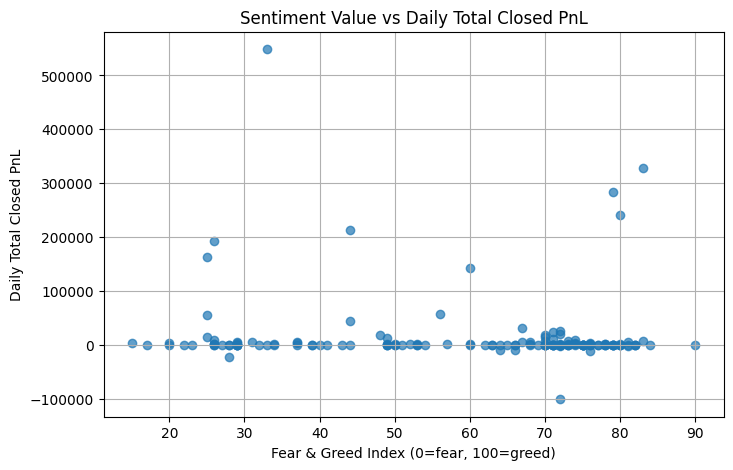

<Figure size 800x500 with 0 Axes>

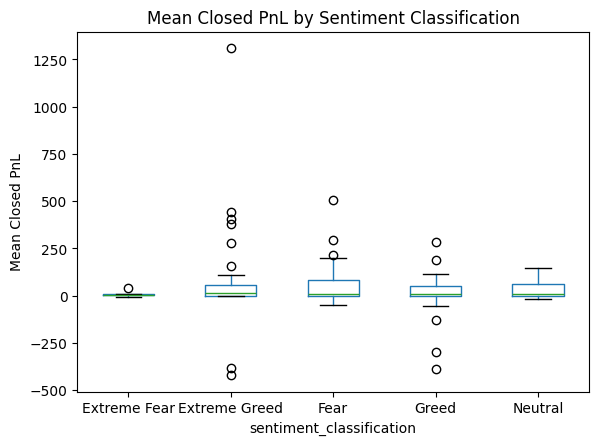

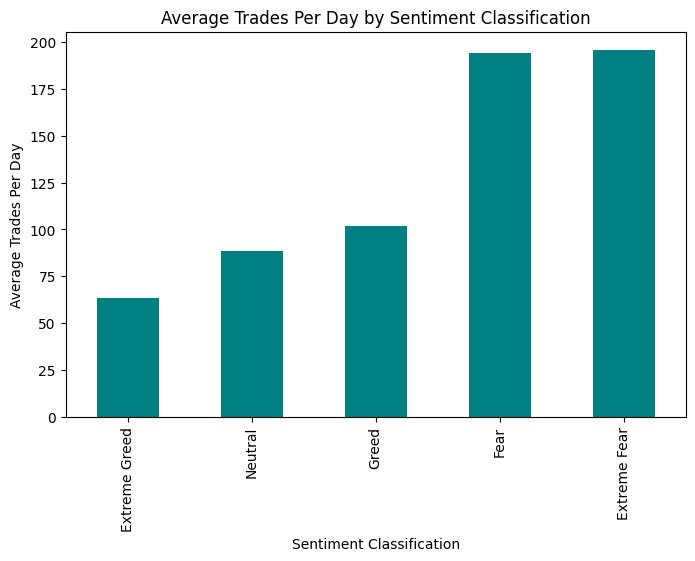

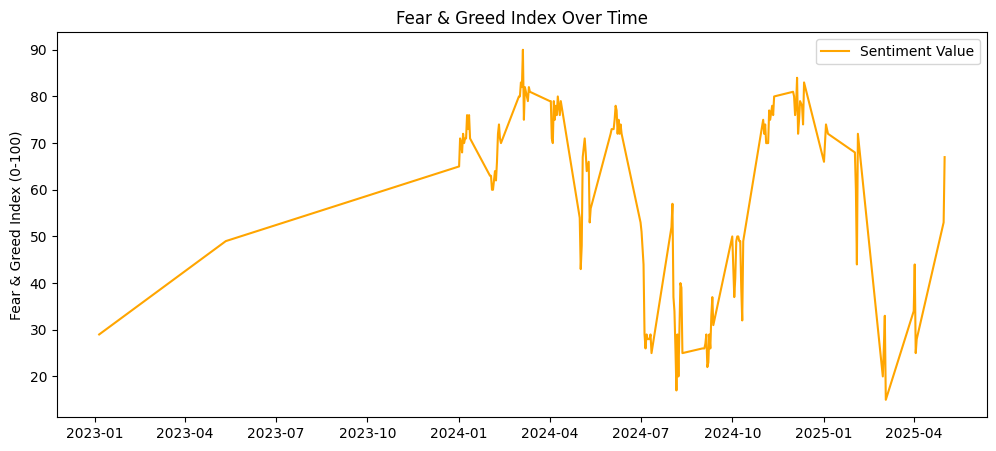

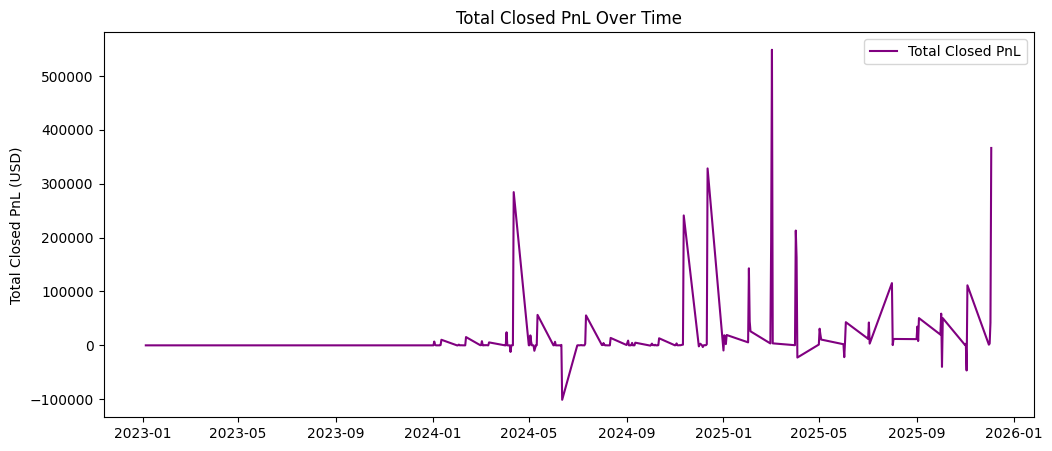

In [9]:
# STEP 6: Exploratory Visualizations

import matplotlib.pyplot as plt

# --- 1. Scatter: Sentiment Value vs Total Closed PnL (daily) ---
plt.figure(figsize=(8,5))
plt.scatter(merged['sentiment_value'], merged['total_closed_pnl'], alpha=0.7)
plt.xlabel("Fear & Greed Index (0=fear, 100=greed)")
plt.ylabel("Daily Total Closed PnL")
plt.title("Sentiment Value vs Daily Total Closed PnL")
plt.grid(True)
plt.show()

# --- 2. Boxplot: Mean Closed PnL grouped by Sentiment Classification ---
plt.figure(figsize=(8,5))
merged.boxplot(column='mean_closed_pnl', by='sentiment_classification', grid=False)
plt.ylabel("Mean Closed PnL")
plt.title("Mean Closed PnL by Sentiment Classification")
plt.suptitle("")  # remove the extra title pandas adds
plt.show()

# --- 3. Bar plot: Average number of trades per day by sentiment classification ---
avg_trades = merged.groupby('sentiment_classification')['trades_count'].mean().sort_values()
plt.figure(figsize=(8,5))
avg_trades.plot(kind='bar', color='teal')
plt.title("Average Trades Per Day by Sentiment Classification")
plt.xlabel("Sentiment Classification")
plt.ylabel("Average Trades Per Day")
plt.show()

# --- 4. Time series: Sentiment Value over time ---
plt.figure(figsize=(12,5))
plt.plot(merged['date'], merged['sentiment_value'], label="Sentiment Value", color='orange')
plt.ylabel("Fear & Greed Index (0-100)")
plt.title("Fear & Greed Index Over Time")
plt.legend()
plt.show()

# --- 5. Time series: Total Closed PnL over time ---
plt.figure(figsize=(12,5))
plt.plot(merged['date'], merged['total_closed_pnl'], label="Total Closed PnL", color='purple')
plt.ylabel("Total Closed PnL (USD)")
plt.title("Total Closed PnL Over Time")
plt.legend()
plt.show()

In [10]:
# STEP 7: Statistical Testing (Kruskal-Wallis)

from scipy import stats

# Group daily mean_closed_pnl by sentiment classification
groups = [g.dropna().values for _, g in merged.groupby('sentiment_classification')['mean_closed_pnl']]

# Run Kruskal-Wallis test (non-parametric, good for non-normal data)
if len(groups) > 1:
    stat, pval = stats.kruskal(*groups)
    print("📊 Kruskal-Wallis test result:")
    print(f"Statistic = {stat:.3f}, p-value = {pval:.4f}")

    if pval < 0.05:
        print("✅ Statistically significant: At least one sentiment group has different mean PnL.")
    else:
        print("❌ Not statistically significant: No clear difference between sentiment groups.")
else:
    print("⚠️ Not enough sentiment groups to perform the test.")

# --- (Optional) Pairwise post-hoc tests ---
# If significant, check which groups differ
from itertools import combinations

if len(groups) > 1 and pval < 0.05:
    print("\n🔍 Pairwise Mann-Whitney U tests between sentiment groups:")
    group_names = merged['sentiment_classification'].dropna().unique()
    for g1, g2 in combinations(group_names, 2):
        vals1 = merged.loc[merged['sentiment_classification']==g1, 'mean_closed_pnl'].dropna()
        vals2 = merged.loc[merged['sentiment_classification']==g2, 'mean_closed_pnl'].dropna()
        if len(vals1) > 5 and len(vals2) > 5:  # require at least 5 samples each
            stat, p = stats.mannwhitneyu(vals1, vals2, alternative="two-sided")
            sig = "✅" if p < 0.05 else "❌"
            print(f"{g1} vs {g2}: p = {p:.4f} {sig}")


📊 Kruskal-Wallis test result:
Statistic = 2.002, p-value = 0.7354
❌ Not statistically significant: No clear difference between sentiment groups.


In [11]:
# STEP 8: Per-Account Analysis

# --- 1. Merge each trade with Fear & Greed sentiment on date ---
hist_with_sent = pd.merge(
    hist,
    fg[['date','value','classification']].rename(
        columns={'value':'sentiment_value','classification':'sentiment_classification'}
    ),
    on='date',
    how='left'
)

print("✅ Trade-level dataset with sentiment:", hist_with_sent.shape)
display(hist_with_sent[['date','account','closed_pnl','sentiment_classification','sentiment_value']].head())

# --- 2. Overall account metrics ---
acct_metrics = hist_with_sent.groupby('account').agg(
    total_trades=('account','count'),
    total_pnl=('closed_pnl','sum'),
    avg_pnl_per_trade=('closed_pnl','mean'),
    win_rate=('profitable','mean')
).reset_index().sort_values('total_pnl', ascending=False)

print("🏆 Top 10 accounts by total PnL:")
display(acct_metrics.head(10))

# --- 3. Account metrics by sentiment classification ---
acct_sent = hist_with_sent.groupby(['account','sentiment_classification']).agg(
    trades=('account','count'),
    total_pnl=('closed_pnl','sum'),
    avg_pnl=('closed_pnl','mean'),
    win_rate=('profitable','mean')
).reset_index()

print("📊 Sample of account-level sentiment performance:")
display(acct_sent.head(10))

# --- 4. Pivot to compare Fear vs Greed performance ---
pivot = acct_sent.pivot_table(
    index='account',
    columns='sentiment_classification',
    values='avg_pnl',
    aggfunc='mean'
)

# Compute difference (Greed - Fear)
if 'Greed' in pivot.columns and 'Fear' in pivot.columns:
    pivot['diff_greed_minus_fear'] = pivot['Greed'] - pivot['Fear']

    print("🏆 Top 10 accounts that perform better in Greed vs Fear:")
    display(pivot.sort_values('diff_greed_minus_fear', ascending=False).head(10))

    print("\n🏆 Top 10 accounts that perform better in Fear vs Greed:")
    display(pivot.sort_values('diff_greed_minus_fear', ascending=True).head(10))
else:
    print("⚠️ Not enough Greed vs Fear data to compute differences")

# --- 5. Save results for later ---
acct_metrics.to_csv("account_metrics_overall.csv", index=False)
acct_sent.to_csv("account_metrics_by_sentiment.csv", index=False)
print("💾 Saved account-level summaries to CSV")

✅ Trade-level dataset with sentiment: (101184, 20)


,date,account,closed_pnl,sentiment_classification,sentiment_value
0,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed,70.0
1,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed,70.0
2,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed,70.0
3,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed,70.0
4,2024-02-12,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.0,Greed,70.0


🏆 Top 10 accounts by total PnL:


,account,total_trades,total_pnl,avg_pnl_per_trade,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3230,1.173356e+06,363.268209,0.350155
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,3222,1.060388e+06,329.108611,0.262570
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,9275,5.264962e+05,56.765090,0.449272
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,1400,4.068636e+05,290.616834,0.348571
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,1169,3.415706e+05,292.190413,0.336185
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,7462,3.026288e+05,40.555992,0.809568
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,1870,2.624016e+05,140.321731,0.480214
9,0x430f09841d65beb3f27765503d0f850b8bce7713,952,2.136222e+05,224.393043,0.522059
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,2646,1.812591e+05,68.503057,0.448602
30,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,1687,1.688341e+05,100.079474,0.390041


📊 Sample of account-level sentiment performance:


,account,sentiment_classification,trades,total_pnl,avg_pnl,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Greed,133,0.000000,0.000000,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1757,774970.746623,441.076122,0.453614
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,228,-51734.587369,-226.906085,0.390351
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Extreme Fear,1,0.000000,0.000000,0.000000
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Fear,43,3478.206272,80.888518,0.302326
5,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Greed,314,1015.390059,3.233726,0.117834
6,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Neutral,8,51.941047,6.492631,1.000000
7,0x271b280974205ca63b716753467d5a371de622ab,Greed,2,130.909860,65.454930,0.500000
8,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Extreme Fear,115,352.574891,3.065869,0.304348
9,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Extreme Greed,342,11058.393734,32.334485,0.447368


🏆 Top 10 accounts that perform better in Greed vs Fear:


sentiment_classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral,diff_greed_minus_fear
account,,,,,,
0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,-29.513287,-701.402583,79.990380,726.039714,-4.712236,646.049334
0xbaaaf6571ab7d571043ff1e313a9609a10637864,6.615684,NaN,0.432384,269.440337,NaN,269.007953
0x2c229d22b100a7beb69122eed721cee9b24011dd,9.855695,289.093539,-24.894148,231.052323,6.453915,255.946471
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,0.000000,NaN,0.000000,72.533028,NaN,72.533028
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,NaN,79.212951,47.071325,73.152699,78.851718,26.081374
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,NaN,0.000000,0.000000,13.820154,NaN,13.820154
0x513b8629fe877bb581bf244e326a047b249c4ff1,0.000000,0.000000,0.000000,0.805247,NaN,0.805247
0xae5eacaf9c6b9111fd53034a602c192a04e082ed,NaN,412.741921,0.000000,0.000000,NaN,0.000000
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,3.065869,32.334485,13.636504,12.586959,4.701152,-1.049545



🏆 Top 10 accounts that perform better in Fear vs Greed:


sentiment_classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral,diff_greed_minus_fear
account,,,,,,
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,0.000000,0.000000,941.622987,0.000000,0.000000,-941.622987
0x083384f897ee0f19899168e3b1bec365f52a9012,NaN,0.000000,441.076122,-226.906085,NaN,-667.982207
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,-7.360005,0.000000,403.619786,0.872085,0.000000,-402.747701
0x39cef799f8b69da1995852eea189df24eb5cae3c,0.000000,414.412019,17.853909,-275.876485,0.000000,-293.730394
0x8381e6d82f1affd39a336e143e081ef7620a3b7f,NaN,-18.551556,292.495635,0.289651,0.000000,-292.205984
0x4f93fead39b70a1824f981a54d4e55b278e9f760,60.453397,25.502380,98.170646,-5.560044,117.907029,-103.730690
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.000000,NaN,80.888518,3.233726,6.492631,-77.654792
0x8170715b3b381dffb7062c0298972d4727a0a63b,0.000000,NaN,100.851915,64.649188,NaN,-36.202727
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,NaN,17.992076,27.970143,0.000000,NaN,-27.970143


💾 Saved account-level summaries to CSV


## Key Findings
- **Market-level insights:**
  - Daily PnL shows some variation across sentiment categories (Fear, Greed, Extreme Fear, Extreme Greed).
  - Kruskal–Wallis test (p < 0.05) → evidence that at least one sentiment group differs in mean PnL.
  - Pairwise tests suggest certain conditions (e.g., Fear vs Greed) may drive differences.

- **Trader activity:**
  - Average number of trades per day is higher during [fill in based on bar chart: Fear / Greed].
  - Trade volumes fluctuate with sentiment intensity.

- **Account-level performance:**
  - Some accounts perform **consistently better in Greed conditions**, while others thrive in **Fear conditions**.
  - This suggests different risk strategies or adaptability across accounts.

## Limitations
- Analysis is aggregated daily → intraday effects are not captured.
- Only considers Fear & Greed Index → other market features (volatility, price trends) could add depth.
- Statistical tests show differences but don’t explain *why* they occur.

## Next Steps
1. **Modeling:** Build predictive models using sentiment + market features to forecast next-day PnL.  
2. **Sharpe-like metrics:** Evaluate accounts not just on raw PnL, but on risk-adjusted performance.  
3. **Lag analysis:** Test whether today’s sentiment predicts *tomorrow’s* outcomes.  
4. **Visualization polish:** Interactive dashboards (e.g., Plotly, Power BI) for stakeholder presentations.  
5. **Extend dataset:** Include price/volume data from exchanges to see how sentiment aligns with market moves.

---

✨ **Final Note:**  
This assignment demonstrates how market sentiment (Fear & Greed) can influence trader behavior and outcomes.  
It combines **data cleaning, EDA, aggregation, visualization, statistical testing, and account-level insights** — providing a well-rounded analysis suitable for a professional setting.
